### Barebones Implementation of SIFT

In [93]:
import cv2 as cv
import numpy as np
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import utils
import math

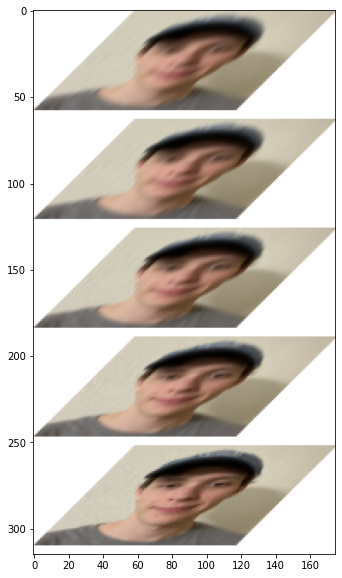

In [94]:
k = math.sqrt(2)
sigma = 1
img = cv.imread("me.PNG", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
n_octaves = 4

octaves = []
for i in range(n_octaves):
    octave = utils.gen_octave(img, 5)
    img = cv.resize(img, (img.shape[0] // 2, img.shape[0] // 2))
    octaves.append(octave)
plt.figure(figsize=(10,10))
#plt.imshow(utils.stack_imgs(octaves[0]), cmap = "gray")
plt.imshow(utils.stack_imgs(octaves[2]))

In [95]:
DoGs = []
sample_octave = octaves[2]
for i, scale in enumerate(sample_octave):
   sample_octave[i] = cv.cvtColor(scale, cv.COLOR_BGR2GRAY)
for i in range(len(sample_octave ) - 1):
    sub_img = sample_octave[i + 1] - sample_octave[i]
    DoGs.append(sub_img)

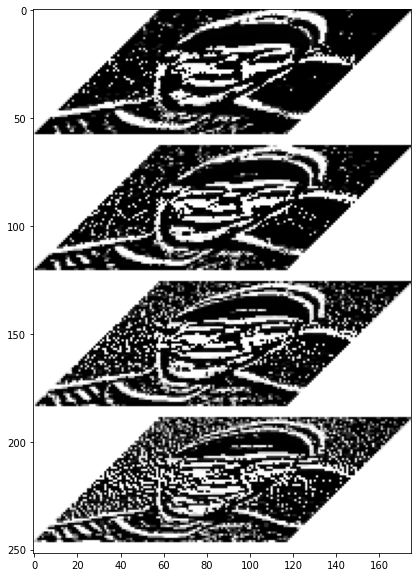

In [96]:
plt.figure(figsize=(10,10))
stacked = utils.stack_imgs(DoGs)
plt.imshow(stacked, cmap = "gray")

In [97]:
candidate1_map, candidates1 = utils.extrema_detection(DoGs, 1)
candidate2_map, candidates2 = utils.extrema_detection(DoGs, 2)
candidates = candidates1 + candidates2

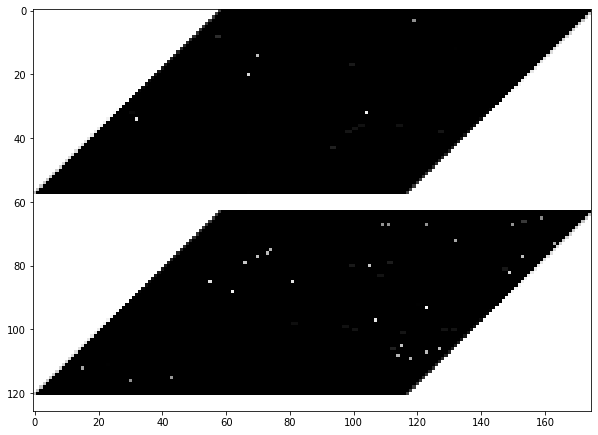

In [98]:
plt.figure(figsize=(10,10))
stacked = utils.stack_imgs([candidate1_map, candidate2_map])
plt.imshow(stacked, cmap = "gray")

In [145]:
def keypoint_inter(DoGs, cands, max_it=5):
    refined = []

    for cand in cands:
        (x, y, s) = cand
        in_neigh, outside = False, False

        for i in range(max_it):
            s_prev, s_curr, s_next = DoGs[s - 1:s + 2]
            neighborhood = np.stack([
                s_prev[y - 1:y + 2, x - 1:x + 2],
                s_curr[y - 1:y + 2, x - 1:x + 2],
                s_next[y - 1:y + 2, x - 1:x + 2],
            ]).astype(np.float32) / 255

            # calculate extremum in the second order Taylor expansion
            offset, contrast = second_order_TE_inter(neighborhood)

            in_neigh = abs(offset[0]) < 0.5 
            in_neigh &= abs(offset[1]) < 0.5 
            in_neigh &= abs(offset[2]) < 0.5 

            # stop if the extremum is in the neighborhood
            if in_neigh: break

            # update extremum
            x += int(round(offset[0]))
            y += int(round(offset[1]))
            s += int(round(offset[2]))

            outside = (x < 1 or x >= s_curr.shape[1] - 1) 
            outside |= (y < 1 or y >= s_curr.shape[0] - 1)
            outside |= (s < 1 or s >= len(DoGs) - 1)

            # discard if extremum is outside the image or scale-space
            if outside: break

        if not in_neigh or outside or abs(contrast) < 0.03:
            continue
        else:
            refined.append((x, y, s))
    
    return refined

def second_order_TE_inter(neigh):
    # Compute first deriv (Gradient) in Taylor series on sample kp
    dx = (neigh[1, 1, 2] - neigh[1, 1, 0]) / 2
    dy = (neigh[1, 2, 1] - neigh[1, 0, 1]) / 2
    ds = (neigh[2, 1, 1] - neigh[0, 1, 1]) / 2
    grad = np.array([dx, dy, ds])

    # Compute second deriv (Hessian) in Taylor series on sample kp
    candidate = neigh[1, 1, 1]
    dxx = neigh[1, 1, 2] - 2 * candidate + neigh[1, 1, 0]
    dyy = neigh[1, 2, 1] - 2 * candidate + neigh[1, 0, 1]
    dss = neigh[2, 1, 1] - 2 * candidate + neigh[0, 1, 1]
    dxy = (neigh[1, 2, 2] - neigh[1, 2, 0] - neigh[1, 0, 2] + neigh[1, 0, 0]) / 4
    dxs = (neigh[2, 1, 2] - neigh[2, 1, 0] - neigh[0, 1, 2] + neigh[0, 1, 0]) / 4
    dys = (neigh[2, 2, 1] - neigh[2, 0, 1] - neigh[0, 2, 1] + neigh[0, 0, 1]) / 4
    hess = np.array([
        [dxx, dxy, dxs], 
        [dxy, dyy, dys],
        [dxs, dys, dss]
    ])

    # Solve for offset and contrast
    z_hat = -np.linalg.inv(hess).dot(grad)
    contrast = candidate + grad.T.dot(z_hat) / 2

    return z_hat, contrast

In [146]:
refined = keypoint_inter(DoGs, candidates)

In [147]:
print(f"number of keypoints before: {len(candidates)}")
print(f"number of keypoints after refinement: {len(refined)}")

number of keypoints before: 85
number of keypoints after refinement: 39
